# Credit Card Fraud Model Training & Evaluation
## Prerequisite

Here, we present the steps of building and training a credit card fraud detection model. We use the autoencoder approach and implement with PyTorch. First of all, import necessary Python modules, especially Numpy, Pandas and PyTorch.

In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

We use the Kaggle [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset here. The datasets contains transactions made by credit cards in September 2013 by European cardholders, and presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

The dataset is in CSV format, with the first row as the header. We first load it as a Pandas DataFrame, and verify its positive and negative samples.

In [3]:
data_file='data/creditcard.csv'
data=pd.read_csv(data_file,header=0)
print('Number of records:',len(data))
print('Positive samples:',len(data[data.Class==0]))
print('Negative samples:',len(data[data.Class==1]))

Number of records: 284807
Positive samples: 284315
Negative samples: 492


The dataset looks like the following. It contains only numerical input variables which are the result of a PCA transformation. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, and the feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data preprocessing
### Choosing positive samples

The autoencoder for fraud detection uses only the positive (non-fraud) samples to train the model, thus only chooses records with Class==0. Then we split the chosen records as train set and test set.

In [5]:
feature_names=data.columns.values[:-1]
train_test_set = data[data.Class==0][feature_names]
print('Train and test set:',len(train_test_set))

Train and test set: 284315


### Splitting into train set and test set

In [6]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(train_test_set, test_size=0.2, random_state=42)

### Data preprocessing using MinMaxScaler

Use Sklearn MinMaxScaler to transform the data value ranges to 0..1. We show the value of the first two rows after transformation.

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler().fit(train_set)
train_set=scaler.transform(train_set)
test_set=scaler.transform(test_set)
train_set[:2]

array([[8.42327013e-01, 9.47367642e-01, 7.97217483e-01, 7.76227227e-01,
        2.41740662e-01, 5.43571003e-01, 5.15661441e-01, 4.19171267e-01,
        8.02040109e-01, 3.17799008e-01, 3.49988397e-01, 2.35464057e-01,
        6.15377573e-01, 4.10107015e-01, 5.99855337e-01, 4.48405051e-01,
        6.02247154e-01, 6.71423155e-01, 6.12703253e-01, 5.13449227e-01,
        4.11165178e-01, 6.10928994e-01, 5.39959714e-01, 6.67924552e-01,
        5.05950311e-01, 5.33984885e-01, 5.03033612e-01, 6.46853527e-01,
        2.57966091e-01, 5.09856012e-03],
       [2.44658194e-01, 9.79105547e-01, 7.97062325e-01, 7.83882282e-01,
        3.03888114e-01, 5.48372609e-01, 5.15350500e-01, 4.21609233e-01,
        7.95745386e-01, 2.79267731e-01, 3.87358807e-01, 3.75257082e-01,
        6.96864586e-01, 5.41487510e-01, 6.50882451e-01, 3.64243237e-01,
        5.45108394e-01, 6.30551391e-01, 5.31712561e-01, 5.85659779e-01,
        4.13125001e-01, 6.06201154e-01, 5.15266633e-01, 6.62486089e-01,
        4.14393519e-01,

Moreover, we can also check the distribution of each feature. The following diagram shows the distribution of the first three and the last features.

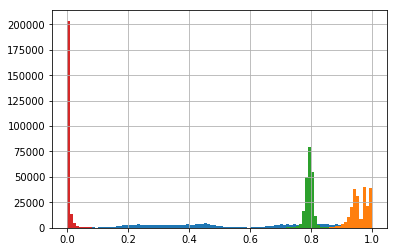

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
pd.Series(train_set[:,0]).hist(bins=100)
pd.Series(train_set[:,1]).hist(bins=100)
pd.Series(train_set[:,2]).hist(bins=100)
pd.Series(train_set[:,-1]).hist(bins=100)

## Modelling and training
### Model definition

Define the autoencoder model with PyTorch. Here, we define 2 hidden layer for each of the encoder and decoder, with 15 and 7 cells respectively, and use ReLU as the activation function.

In [9]:
class autoencoder(nn.Module):
    def __init__(self,num_input):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_input, 15),
            nn.ReLU(True),
            nn.Linear(15, 7))
        self.decoder = nn.Sequential(
            nn.Linear(7, 15),
            nn.ReLU(True),
            nn.Linear(15, num_input),
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Defining data loader

In [10]:
batch_size = 256
num_workers = 4

inputs = torch.tensor(train_set, dtype=torch.float32)
dataset = TensorDataset(inputs)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

### Defining loss function and optimizer

In [11]:
lr = 0.01

model = autoencoder(inputs.shape[1])
model = model.cuda() if torch.cuda.is_available() else model
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

### Defining test function

The test function is used for cross validation during the training. Here we choose to do cross validation for each 5 epochs.

In [12]:
def test():
    model.eval()

    with torch.no_grad():
        if torch.cuda.is_available():
            tests_=torch.tensor(test_set, dtype=torch.float32).cuda()
        else:
            tests_=torch.tensor(test_set, dtype=torch.float32)
        outputs = model(tests_)
        loss=criterion(outputs,tests_)
    #print(tests_,outputs)
    return loss.item()/(tests_.shape[0]*tests_.shape[1])

### Model training

In [13]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    loss_sum=0.0; num=0
    for inputs, in dataloader:
        if torch.cuda.is_available():
            inputs=inputs.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        loss_sum+=loss.item()
        num+=(inputs.shape[0]*inputs.shape[1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%5 == 0:
        print('{} epoch [{}/{}], loss:{:.6f}, test_set_loss:{:.6f}'
                .format(datetime.now(), epoch + 1, num_epochs, loss_sum/num, test()))

2020-05-10 18:32:05.161102 epoch [5/100], loss:0.001350, test_set_loss:0.001348
2020-05-10 18:32:11.249185 epoch [10/100], loss:0.001302, test_set_loss:0.001304
2020-05-10 18:32:17.820717 epoch [15/100], loss:0.001282, test_set_loss:0.001275
2020-05-10 18:32:24.841254 epoch [20/100], loss:0.001267, test_set_loss:0.001259
2020-05-10 18:32:31.619783 epoch [25/100], loss:0.001244, test_set_loss:0.001235
2020-05-10 18:32:38.562468 epoch [30/100], loss:0.001235, test_set_loss:0.001236
2020-05-10 18:32:44.932958 epoch [35/100], loss:0.001235, test_set_loss:0.001231
2020-05-10 18:32:51.896279 epoch [40/100], loss:0.001227, test_set_loss:0.001231
2020-05-10 18:32:59.101634 epoch [45/100], loss:0.001225, test_set_loss:0.001230
2020-05-10 18:33:06.707046 epoch [50/100], loss:0.001225, test_set_loss:0.001233
2020-05-10 18:33:14.098740 epoch [55/100], loss:0.001221, test_set_loss:0.001220
2020-05-10 18:33:21.447746 epoch [60/100], loss:0.001223, test_set_loss:0.001231
2020-05-10 18:33:28.704236 ep

## Model evaluation
### Inference with trained model

To inference with the trained model, we do the following:

* Preprocess the records using the MinMaxScaler (the *scaler* variable) defined and trained in the *Data preprocessing using MinMaxScaler* section.
* Use the preprocessed data as the input vectors of the model, and compute the output vectors by feed forward.
* Calculate the root square of the input and output vectors, i.e. the generation losses.
* For those whose generation losses are greater than a predefined threshold (as for how to calculate the value of the threshold, see the discussion below), we score them as *fraud*; otherwise, score as *normal*.

The value of the threshold is actually calculated via the distribution of the generation losses. Thus let's first show the generation losses of the trained model for the *normal* and *fraud* cases.

### Distribution of generation losses

As the dataset is highly unbalanced, we take the whole positive (fraud) records while randomly choosing the equal number of negative (normal) records. The diagram below shows the results.

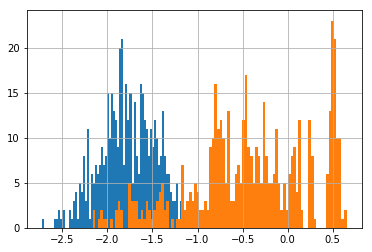

In [14]:
model.eval()

with torch.no_grad():
    test_set2 = data[data.Class==1][feature_names]
    test_set2=scaler.transform(test_set2)
    inputs2=torch.tensor(test_set2, dtype=torch.float32)
    outputs2=model(inputs2)
    loss2=torch.sum((inputs2-outputs2)**2,dim=1).sqrt().log()

    test_set1=test_set[np.random.choice(len(test_set),size=len(loss2),replace=False)]
    inputs1=torch.tensor(test_set1, dtype=torch.float32)
    outputs1=model(inputs1)
    loss1=torch.sum((inputs1-outputs1)**2,dim=1).sqrt().log()

    pd.Series(loss1.numpy()).hist(bins=100)
    pd.Series(loss2.numpy()).hist(bins=100)

### Calculation of threshold (*split point*)

If the distribution functions of the generation losses are the convex function, the threshold is very easy to calculation. It is the just the intersection of the positive-case and negative-case distribution functions. However, as we see from the diagram above, neither of the distribution function is strictly convex.

Here, we define the threshold as the split point that maximize the average precise in both positive and negative cases. And use a *5-points* heuristic search approach to find the split point (see the **find_split_point** function).

Initially, we define the search range as the minimum generation loss of the positive cases and the maximum of the negative cases. For each iteration, we pick up half of the search range using the heuristic function to evaluate the picked range contains the split point. When the search range is smaller than 0.01, the iterations stop.

In [15]:
def precise_rate(split_point):
    rate1=(loss1<split_point).sum().item()/float(len(loss1))
    rate2=(loss2>split_point).sum().item()/float(len(loss2))
    return (rate1+rate2)/2            

def find_split_point(start,end,start_precise,end_precise):
    print(start,'->',end)
    delta=(end-start)/4.0
    precise=[start_precise]
    precise+=[precise_rate(start+i*delta) for i in range(1,4)]
    precise+=[end_precise]

    i = 0 if sum(precise[0:3])>sum(precise[1:4]) else 1
    j = i if sum(precise[i:i+3])>sum(precise[2:5]) else 2

    if end-start>0.01:
        return find_split_point(start+j*delta,start+(j+2)*delta,precise[j],precise[j+2])
    else:
        return start+delta*np.argmax(precise)


(start,end)=(loss1.max().item(),loss2.min().item())
(start,end)=(start,end) if start<end else (end,start)
split_point=find_split_point(start,end,precise_rate(start),precise_rate(end))
print('\nSplit point:',split_point)

-2.1654911041259766 -> -0.46983790397644043
-1.3176645040512085 -> -0.46983790397644043
-1.3176645040512085 -> -0.8937512040138245
-1.2116861790418625 -> -0.9997295290231705
-1.2116861790418625 -> -1.1057078540325165
-1.2116861790418625 -> -1.1586970165371895
-1.185191597789526 -> -1.1586970165371895
-1.1719443071633577 -> -1.1586970165371895
-1.1653206618502736 -> -1.1586970165371895

Split point: -1.1620088391937315


From the outputs above, we can see how the search range shrinks with each iterations, and the final split point calculated.

### Model precise rate

In [19]:
precise1=(loss1<split_point).sum().item()/float(len(loss1))
precise2=(loss2>split_point).sum().item()/float(len(loss2))
print('Precise rate for normal cases:',precise1)
print('Precise rate for fraud cases:',precise2)
print('Overall precise:',(precise1+precise2)/2)

Precise rate for normal cases: 0.967479674796748
Precise rate for fraud cases: 0.8719512195121951
Overall precise: 0.9197154471544715


### Saving model

In [20]:
#torch.save(model.state_dict(), 'creditcard-fraud-2.model')